# Librerias

In [231]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
import tensorflow as tf

# Warnings

In [232]:
warnings.filterwarnings('always')
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Datasets

In [233]:
ruta_hotels_train = "df_hotel_train_clean.csv"
ruta_hotels_test = "df_hotel_test_clean.csv"
ds_hotels_train = pd.read_csv(ruta_hotels_train)
ds_hotels_test = pd.read_csv(ruta_hotels_test)
df_hotels_train = ds_hotels_train.copy()
df_hotels_test = ds_hotels_test.copy()

# Preparacion

In [234]:
target = "is_canceled"

Verifico balanceo

In [235]:
df_hotels_train[target].value_counts(normalize=True)

is_canceled
1    0.50384
0    0.49616
Name: proportion, dtype: float64

In [236]:
features = list(df_hotels_train.columns)
features.remove(target)

Separo sets de entranamiento y evaluacion

In [237]:
x_train, x_test, y_train, y_test = train_test_split(df_hotels_train[features], 
                                                    df_hotels_train[target], 
                                                    test_size=0.3, random_state=42, 
                                                    stratify=df_hotels_train[target])

Verifico la cantidad de datos en ambos sets

In [238]:
print("Datos Entrenamiento: {}".format(len(x_train)))
print("Datos Prueba: {}".format(len(x_test)))

Datos Entrenamiento: 41748
Datos Prueba: 17892


Asi quedaron balanceados

In [239]:
for split_name, split in zip(["% Positivos Entrenamiento", "% Positivos Prueba"], [y_train, y_test]):
  print('{}: {:.3f}'.format(split_name, pd.Series(split).value_counts(normalize=True)[1] * 100))

% Positivos Entrenamiento: 50.383
% Positivos Prueba: 50.386


Escalo datos

In [240]:
columnas_numericas = x_train.select_dtypes(include=["number"]).columns.tolist()
sscaler = StandardScaler()
sscaler.fit(pd.DataFrame(x_train[columnas_numericas]))

StandardScaler()

In [241]:
x_train_transform_1 = sscaler.transform(pd.DataFrame(x_train[columnas_numericas]))
x_test_transform_1 = sscaler.transform(pd.DataFrame(x_test[columnas_numericas]))

In [242]:
for i in range(len(columnas_numericas)):
  x_train[columnas_numericas[i]] = x_train_transform_1[:,i]
  x_test[columnas_numericas[i]] = x_test_transform_1[:,i]

# Red neuronal

Calculo la cantidad de clases

In [243]:
cantidad_neuronas_ocultas = 64
tamanio_batch = 32
cantidad_clases = len(np.unique(y_train))
dimension_input = len(x_train.columns)
cantidad_neuronas_ocultas = 64
modelo = keras.Sequential([
    keras.layers.Input(shape=(x_train.shape[1],)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
modelo.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 128)               7680      
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dense_44 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16001 (62.50 KB)
Trainable params: 16001 (62.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compilacion

In [244]:
cantidad_epochs = 100
modelo.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss="binary_crossentropy", metrics=["AUC"])
modelo_historia = modelo.fit(x_train, y_train, epochs=cantidad_epochs, batch_size=tamanio_batch, verbose=False)

## Prediccion

560/560 [==============================] - 0s 500us/step
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      8877
           1       0.82      0.88      0.85      9015

    accuracy                           0.84     17892
   macro avg       0.84      0.84      0.84     17892
weighted avg       0.84      0.84      0.84     17892



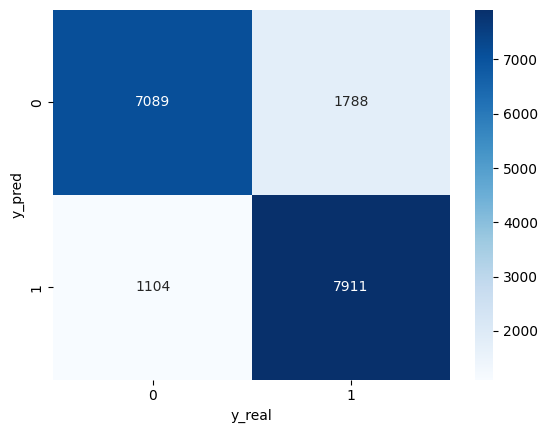

In [245]:
y_predic = modelo.predict(x_test)
y_predic_cat = np.where(y_predic > 0.4, 1, 0)
ds_validacion = pd.DataFrame(y_predic_cat, y_test).reset_index()
ds_validacion.columns = ["y_pred", "y_real"]
print(classification_report(ds_validacion.y_pred, ds_validacion.y_real))
tabla = pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grafico = sns.heatmap(tabla, annot=True, cmap="Blues", fmt='g')
plt.show()

In [246]:
print("f1 score: ", f1_score(y_test, y_predic_cat))

f1 score:  0.8454632895158706


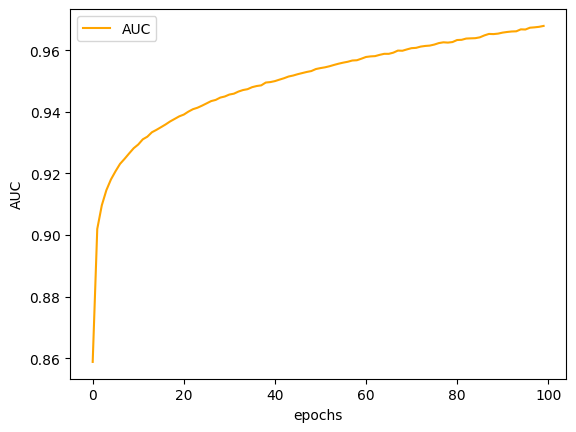

In [247]:
epochs = range(cantidad_epochs)
plt.plot(epochs, modelo_historia.history["auc"], color="orange", label="AUC")
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

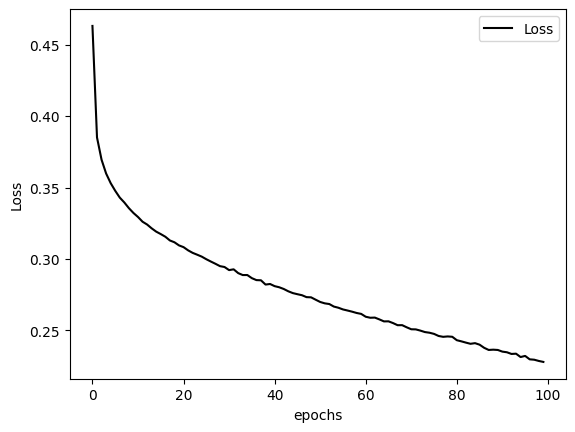

In [248]:
epochs = range(cantidad_epochs)
plt.plot(epochs, modelo_historia.history['loss'], color='black', label='Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()